# Clustering with SPRITE postprocessing

Clustering of cells by predicted spatial gene expression with and without SPRITE postprocessing. Generates results associated with Figure 4 of the manuscript.

The notebook requires data files generated by the ``impute.py`` script run on all benchmark datasets.


Things to keep in mind for interpretation:

- Rand Score is defined here with respect to the true ground truth clustering (e.g. cell type annotation) and provides a measure of how well the clusters match with the ground truth
- Silhouette Score is a measure of the goodness of separation provided by the clustering (i.e. if the clusters are well separated) but doesn't say much about how correct the clusters are

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
from scipy.stats import pearsonr, spearmanr
import anndata as ad
import seaborn as sns
import pickle

from main import *
from downstream import *

from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.stats import ttest_rel
from decimal import Decimal

In [2]:
# paths to results files (anndata)

filenames = ["scg_results/Dataset3_knn_spage_tangram.h5ad",
             "scg_results/Dataset9_knn_spage_tangram.h5ad",
             "scg_results/Dataset11_knn_spage_tangram.h5ad",
             "scg_results/Dataset12_knn_spage_tangram.h5ad",
             "scg_results/Dataset13_knn_spage_tangram.h5ad",
             "scg_results/Dataset14_knn_spage_tangram.h5ad",
             "scg_results/Dataset15_knn_spage_tangram.h5ad",
             "scg_results/Dataset17_knn_spage_tangram.h5ad",
             "scg_results/Axolotl_knn_spage_tangram.h5ad",
             "scg_results/Dataset7_knn_spage_tangram.h5ad",
             "scg_results/Dataset1_knn_spage_tangram.h5ad",
             ]

### Using known metadata labels for the clustering

Only Axolotl, Dataset 15, Dataset 1 have metadata associated with their original datasets for cell type

In [ ]:
dataset_names = ["Dataset15", "Dataset1", "Axolotl"]
metadata_labels = ["ClusterName", "celltype_mapped_refined", "Annotation"]

models = ['knn', 'spage', 'tangram']


######################################

clustering_results_dict = {}

for di, d in enumerate(dataset_names):

    # read in data
    adata = sc.read_h5ad(f'scg_results/{d}_knn_spage_tangram.h5ad')
    if os.path.isfile(fn):
        adata = sc.read_h5ad(f'scg_results/{d}_knn_spage_tangram.h5ad')
    else:
        adata = large_load(f'scg_results/{d}_knn_spage_tangram')
    #adata_copy = adata.copy()

    # Get ground truth clustering
    label = metadata_labels[di]
    true_clusters = adata.obs[label]

    # set up dict
    dataset_name = d+'_'+label
    clustering_results_dict[dataset_name] = {}
    for model in models:
        clustering_results_dict[dataset_name][model] = {}
        clustering_results_dict[dataset_name][model]['raw'] = {'silhouette':[], 'ari':[]} # using only measured genes
        clustering_results_dict[dataset_name][model]['baseline'] = {'silhouette':[], 'ari':[]} # using only baseline imputations
        clustering_results_dict[dataset_name][model]['sprite'] = {'silhouette':[], 'ari':[]}
    
    for model in models:
        # get gene expression matrices
        add_baseline_imp = adata.obsm[model+"_predicted_expression_raw"].values.copy()
        add_sprite_imp = adata.obsm["smoothed_reinforced_gene_joint_"+model+"_predicted_expression_raw"].values.copy()

        # baseline -- raw + baseline imputed
        temp_adata = ad.AnnData(add_baseline_imp, dtype=add_baseline_imp.dtype)
        temp_adata.obs_names = adata.obs_names
        #temp_adata.var_names = np.concatenate((sub_adata.var_names, imp_gene_names))
        baseline_clusters, X_pca_baseline = leiden_clustering(temp_adata)
        del temp_adata

        # sprite -- raw + sprite imputed
        temp_adata = ad.AnnData(add_sprite_imp, dtype=add_sprite_imp.dtype)
        temp_adata.obs_names = adata.obs_names
        #temp_adata.var_names = np.concatenate((sub_adata.var_names, imp_gene_names))
        sprite_clusters, X_pca_sprite = leiden_clustering(temp_adata)
        del temp_adata


        # compute metrics for different setups (Silhouette, ARI)
        clustering_results_dict[dataset_name][model]['baseline']['silhouette'].append(silhouette_score(X_pca_baseline, baseline_clusters))
        clustering_results_dict[dataset_name][model]['baseline']['ari'].append(adjusted_rand_score(true_clusters, baseline_clusters))

        clustering_results_dict[dataset_name][model]['sprite']['silhouette'].append(silhouette_score(X_pca_sprite, sprite_clusters))
        clustering_results_dict[dataset_name][model]['sprite']['ari'].append(adjusted_rand_score(true_clusters, sprite_clusters))

In [32]:
# with open('clustering_results_dict_AxD1D15_metadatalabels.pkl', 'wb') as handle:
#     pickle.dump(clustering_results_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('clustering_results_dict_AxD1D15_metadatalabels.pkl', 'rb') as handle:
    clustering_results_dict = pickle.load(handle)

In [33]:
# Plotting results

comb_df = pd.DataFrame([])

dataset_names = ["Dataset15", "Dataset1", "Axolotl"]
metadata_labels = ["ClusterName", "celltype_mapped_refined", "Annotation"]

models = ['knn', 'spage', 'tangram']

for i in range(len(dataset_names)):
    
    dataset_name = dataset_names[i]+"_"+metadata_labels[i]
        
    for model in models:
        
        silhouettes = np.concatenate((clustering_results_dict[dataset_name][model]['raw']['silhouette'],
                                      clustering_results_dict[dataset_name][model]['baseline']['silhouette'],
                                      clustering_results_dict[dataset_name][model]['sprite']['silhouette']))
        aris = np.concatenate((clustering_results_dict[dataset_name][model]['raw']['ari'],
                                      clustering_results_dict[dataset_name][model]['baseline']['ari'],
                                      clustering_results_dict[dataset_name][model]['sprite']['ari']))
        input_data = np.concatenate((len(clustering_results_dict[dataset_name][model]['raw']['ari'])*["raw"],
                                     len(clustering_results_dict[dataset_name][model]['baseline']['ari'])*["baseline"],
                                     len(clustering_results_dict[dataset_name][model]['sprite']['ari'])*["sprite"]))
        df = pd.DataFrame(np.vstack((silhouettes,aris,input_data)).T,
                         columns=["Silhouette", "ARI", "Data"])
        df["Silhouette"] = df["Silhouette"].astype(float)
        df["ARI"] = df["ARI"].astype(float)
        df["Dataset_Name"] = dataset_name
        
        comb_df = pd.concat((comb_df,df))

## Figure 4B: Adjusted rand index for SPRITE clustering quality

In [3]:
with open('clustering_results_dict_AxD1D15_metadatalabels.pkl', 'rb') as handle:
    clustering_results_dict = pickle.load(handle)

In [4]:
# Plotting results

comb_df = pd.DataFrame([])

dataset_names = ["Dataset15", "Dataset1", "Axolotl"]
metadata_labels = ["ClusterName", "celltype_mapped_refined", "Annotation"]

models = ['knn', 'spage', 'tangram']

for i in range(len(dataset_names)):
    
    dataset_name = dataset_names[i]+"_"+metadata_labels[i]
        
    for model in models:
        
        silhouettes = np.concatenate((clustering_results_dict[dataset_name][model]['raw']['silhouette'],
                                      clustering_results_dict[dataset_name][model]['baseline']['silhouette'],
                                      clustering_results_dict[dataset_name][model]['sprite']['silhouette']))
        aris = np.concatenate((clustering_results_dict[dataset_name][model]['raw']['ari'],
                                      clustering_results_dict[dataset_name][model]['baseline']['ari'],
                                      clustering_results_dict[dataset_name][model]['sprite']['ari']))
        input_data = np.concatenate((len(clustering_results_dict[dataset_name][model]['raw']['ari'])*["raw"],
                                     len(clustering_results_dict[dataset_name][model]['baseline']['ari'])*["baseline"],
                                     len(clustering_results_dict[dataset_name][model]['sprite']['ari'])*["sprite"]))
        df = pd.DataFrame(np.vstack((silhouettes,aris,input_data)).T,
                         columns=["Silhouette", "ARI", "Data"])
        df["Silhouette"] = df["Silhouette"].astype(float)
        df["ARI"] = df["ARI"].astype(float)
        
        comb_df = pd.concat((comb_df,df))

/tmp/ipykernel_3861/3391608001.py:7: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=comb_df, x="Data", y="ARI", palette=plot_palette2, ax=ax)


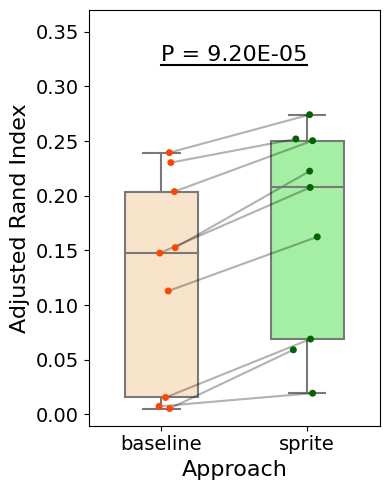

In [9]:
fig, ax = plt.subplots(figsize=(4,5))

plot_palette = {"baseline": "bisque", "sprite": "palegreen"}
plot_palette2 = {"baseline": "orangered", "sprite": "darkgreen"}

# add points
sns.stripplot(data=comb_df, x="Data", y="ARI", palette=plot_palette2, ax=ax)
sns.boxplot(data=comb_df, x="Data", y="ARI", palette=plot_palette, ax=ax, width=0.5)#, showfliers=False)

    
# Draw connecting lines
locs1 = ax.get_children()[0].get_offsets()
locs2 = ax.get_children()[1].get_offsets()
for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.3)
    
# statistical annotation
x_coords = [0.5]
y_coords = [0.32]
cols = ['k']
h = 0
w = 0.5
t,p = ttest_rel(comb_df[comb_df["Data"]=="baseline"]["ARI"], comb_df[comb_df["Data"]=="sprite"]["ARI"])
pval_labels = [p]
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)
    
plt.ylim(None, y+0.05)
    
plt.xlabel("Approach", fontsize=16)
plt.ylabel("Adjusted Rand Index", fontsize=16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('plots/sprite_clustering/metadata_AxD1D15_ARI.pdf')
plt.show()

NOTE: Average Silhouette score increased but was not statistically significant (P>0.05)